#

Data Understanding

In [ ]:
from google.colab import files
import zipfile
import os
from google.colab import drive



drive.mount('/content/drive')



DATA_DIR = "/content/drive/MyDrive/Data"




Mounted at /content/drive


In [ ]:
# General libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Deep learning / Image processing
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1, preprocess_input
from tensorflow.keras.utils import to_categorical


In [ ]:
 #Set base path to your dataset folder
base_path =  "/content/drive/MyDrive/Data"

train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "valid")
test_dir = os.path.join(base_path, "test")

print("Train Directory:", train_dir)
print("Validation Directory:", val_dir)
print("Test Directory:", test_dir)



Train Directory: /content/drive/MyDrive/Data/train
Validation Directory: /content/drive/MyDrive/Data/valid
Test Directory: /content/drive/MyDrive/Data/test


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'normal': 13, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


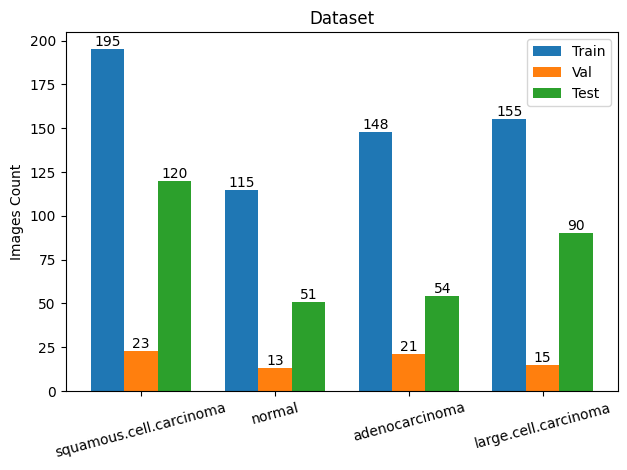

In [ ]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # count files in the folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

# Get the number of images per class in each set (train, validation and test)
train_set = GetDatasetSize(train_dir)
val_set = GetDatasetSize(val_dir)
test_set = GetDatasetSize(test_dir)
print(train_set,"\n\n",val_set,"\n\n",test_set)


# Labels for each classs
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']

# Create lists from previous dictionaries storing the count of images per category
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

# Labels location and bars widht
x = np.arange(len(labels))
width = 0.25

# Create plot and 3 sets of bars (train, val, test)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add labels, title, legend, count values...
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()
ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

# Optimized layout and displaying plot
fig.tight_layout()
plt.show()

Data Preprocesing and Data Augmentation

In [ ]:
# Image input settings for EfficientNetB1
IMG_SIZE = (240, 240)
BATCH_SIZE = 32


In [ ]:


# ✅ Training data with augmentation
train_datagen = ImageDataGenerator(

    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    preprocessing_function=preprocess_input
)


# ✅ Validation and test data (NO augmentation, just preprocessing)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)




print(train_generator.class_indices)



Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


Found 613 images belonging to 4 classes.


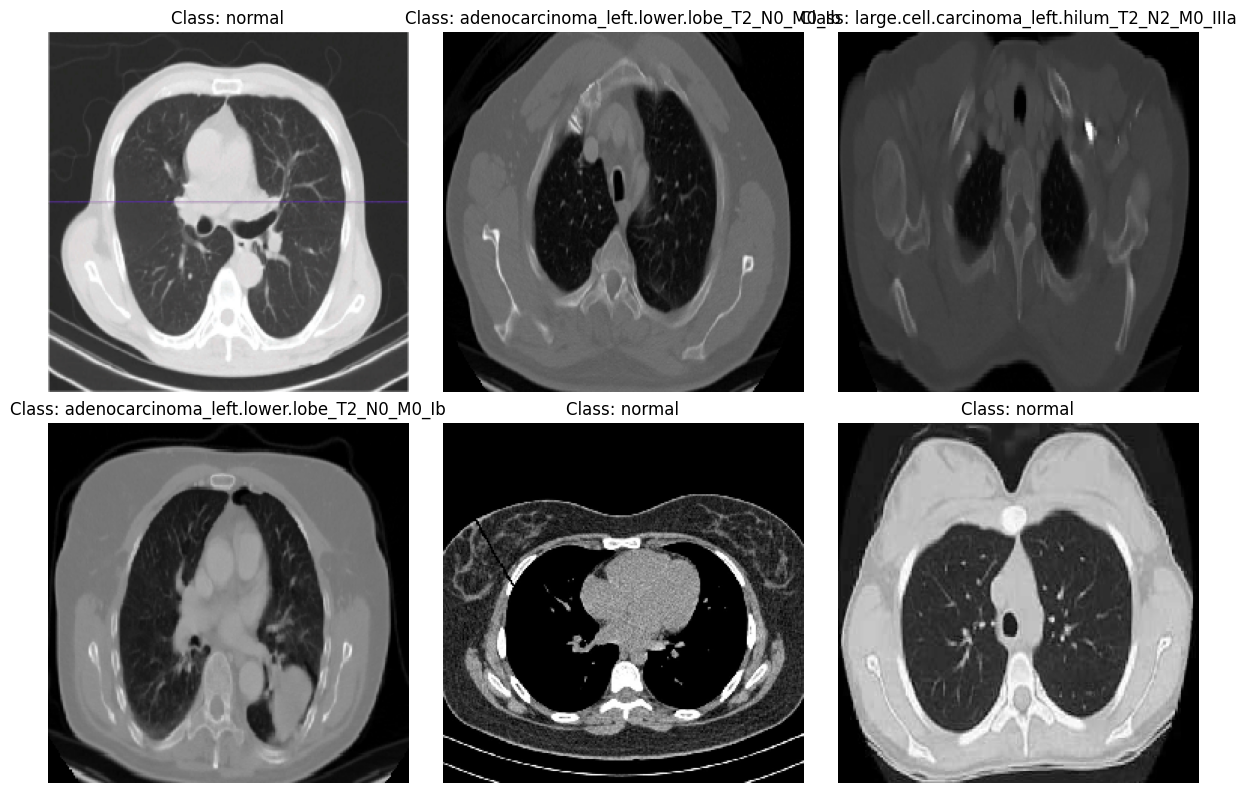

In [ ]:
# ✅ Visualization generator (no preprocessing or augmentation)
vis_datagen = ImageDataGenerator(rescale=1./255)

vis_generator = vis_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=6,
    class_mode='categorical',
    shuffle=True
)

# ✅ Visualize a few samples from training dataset (correctly scaled for viewing)
class_names = list(train_generator.class_indices.keys())
vis_images, vis_labels = next(vis_generator)

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(vis_images[i])  # No need to un-preprocess anymore
    plt.title(f"Class: {class_names[np.argmax(vis_labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Modelling

In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam



base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(240, 240, 3))



# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dropout(0.5)(x)  # Regularization
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

Epoch 1/32
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6494 - loss: 0.8917 
Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to /content/drive/MyDrive/lung_project/models_b1/best_B1_model_training.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 488s 24s/step - accuracy: 0.6526 - loss: 0.8838 - val_accuracy: 0.4583 - val_loss: 2.3946 - learning_rate: 0.0010
Epoch 2/32
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.8726 - loss: 0.3727 
Epoch 2: val_accuracy improved from 0.45833 to 0.69444, saving model to /content/drive/MyDrive/lung_project/models_b1/best_B1_model_training.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 440s 22s/step - accuracy: 0.8731 - loss: 0.3705 - val_accuracy: 0.6944 - val_loss: 0.8728 - learning_rate: 0.0010
Epoch 3/32
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9089 - loss: 0.2145 
Epoch 3: val_accuracy improved from 0.69444 to 0.70833, saving model to /content/drive/MyDrive/lung_project/models_b1/best_B1_model_training.keras
20/20 ━━━━━━━━━━━━━━━━━━━

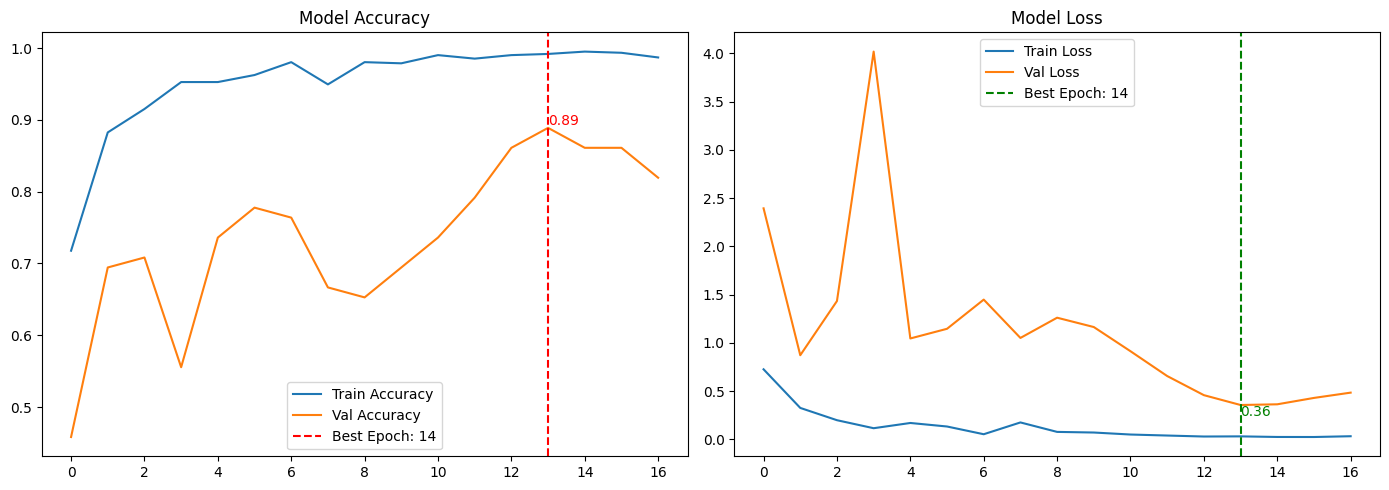

🏁 Final Training Accuracy: 0.9869
🏁 Best Validation Accuracy: 0.8889


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



# ===============================
# Step 1: Set up callbacks
# ===============================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
     ModelCheckpoint("/content/drive/MyDrive/lung_project/models_b1/best_B1_model_training.keras", monitor='val_accuracy', save_best_only=True, verbose=1),

    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-6)
]




# ===============================
# Step 3: Initial Training (before fine-tuning)
# ===============================
history = model.fit(
    train_generator,
    epochs=32,
    validation_data=val_generator,
    callbacks=callbacks
)




# Re-compile model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train again (fine-tuning phase)
history2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

# === Combine History ===
acc = history.history['accuracy'] + history2.history['accuracy']
val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']
loss = history.history['loss'] + history2.history['loss']
val_loss = history.history['val_loss'] + history2.history['val_loss']
epochs_range = range(len(acc))

# === Plot Accuracy and Loss ===
import matplotlib.pyplot as plt

best_epoch_acc = val_acc.index(max(val_acc))
best_val_acc = max(val_acc)
best_epoch_loss = val_loss.index(min(val_loss))
best_val_loss = min(val_loss)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.axvline(best_epoch_acc, color='red', linestyle='--', label=f'Best Epoch: {best_epoch_acc+1}')
plt.text(best_epoch_acc, best_val_acc, f'{best_val_acc:.2f}', color='red', verticalalignment='bottom')
plt.title('Model Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.axvline(best_epoch_loss, color='green', linestyle='--', label=f'Best Epoch: {best_epoch_loss+1}')
plt.text(best_epoch_loss, best_val_loss, f'{best_val_loss:.2f}', color='green', verticalalignment='top')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Final results
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
print(f"🏁 Final Training Accuracy: {final_train_acc:.4f}")
print(f"🏁 Best Validation Accuracy: {best_val_acc:.4f}")





```
# This is formatted as code
```

Model Evaluation and Prediction on Validation Set


Evaluating model on validation data...
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8976 - loss: 0.3337
Validation Loss and Accuracy: [0.3570175766944885, 0.8888888955116272]
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 163ms/step

Classification Results Table:

+--------------------------------------------------+-------------+----------+------------+-----------------------+
| Classes                                          |   precision |   recall |   f1-score |   Validation Accuracy |
+==================================================+=============+==========+============+=======================+
| adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       |    0.793103 | 1        |   0.884615 |              100      |
+--------------------------------------------------+-------------+----------+------------+-----------------------+
| large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa    |    0.947368 | 0.857143 |   0.9      |               85.7143 |
+--------------------------------------------------+--

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


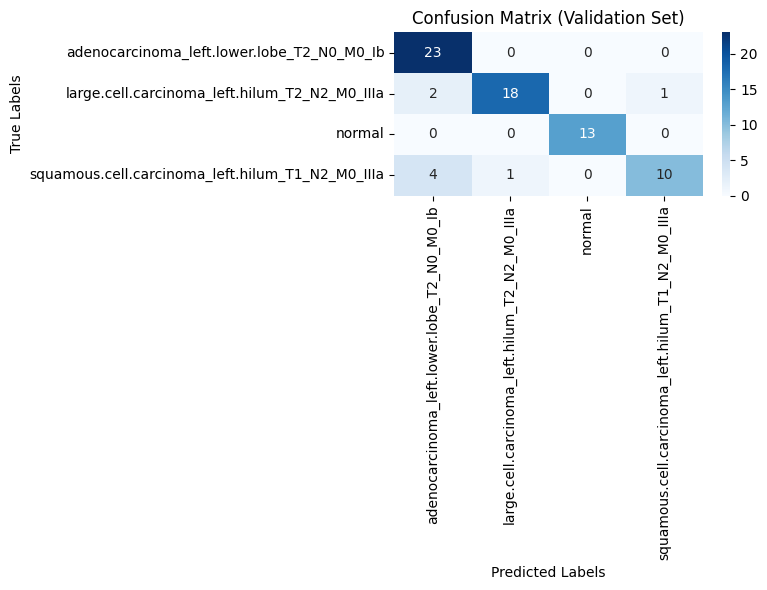

In [ ]:


import random
import seaborn as sns
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# ✅ Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)





# ✅ Load and compile the model
model.load_weights("/content/drive/MyDrive/lung_project/models_b1/best_B1_model_training.keras")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Evaluate on validation set
print("\nEvaluating model on validation data...")
val_acc = model.evaluate(val_generator)
print("Validation Loss and Accuracy:", val_acc)

# ✅ Predict on validation set
Y_pred_probs = model.predict(val_generator, steps=val_generator.samples, verbose=1)
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)

# ✅ Actual labels
Y_true = np.array(val_generator.classes, dtype=np.int32)

# ✅ Class labels
class_labels = list(val_generator.class_indices.keys())

# ✅ Classification report
report = classification_report(Y_true, Y_pred_classes, target_names=class_labels, output_dict=True)
df_report = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']]
df_report = df_report.iloc[:-3]  # remove avg/accuracy rows

# ✅ Per-class accuracy
df_report['Validation Accuracy'] = [
    accuracy_score(Y_true[Y_true == i], Y_pred_classes[Y_true == i]) * 100
    for i in range(len(class_labels))
]
df_report.index.name = 'Classes'
overall_accuracy = accuracy_score(Y_true, Y_pred_classes) * 100

# ✅ Print report
print("\nClassification Results Table:\n")
print(df_report.to_markdown(tablefmt='grid'))
print(f"\nOverall Validation Accuracy: {overall_accuracy:.2f}%")

# ✅ Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()


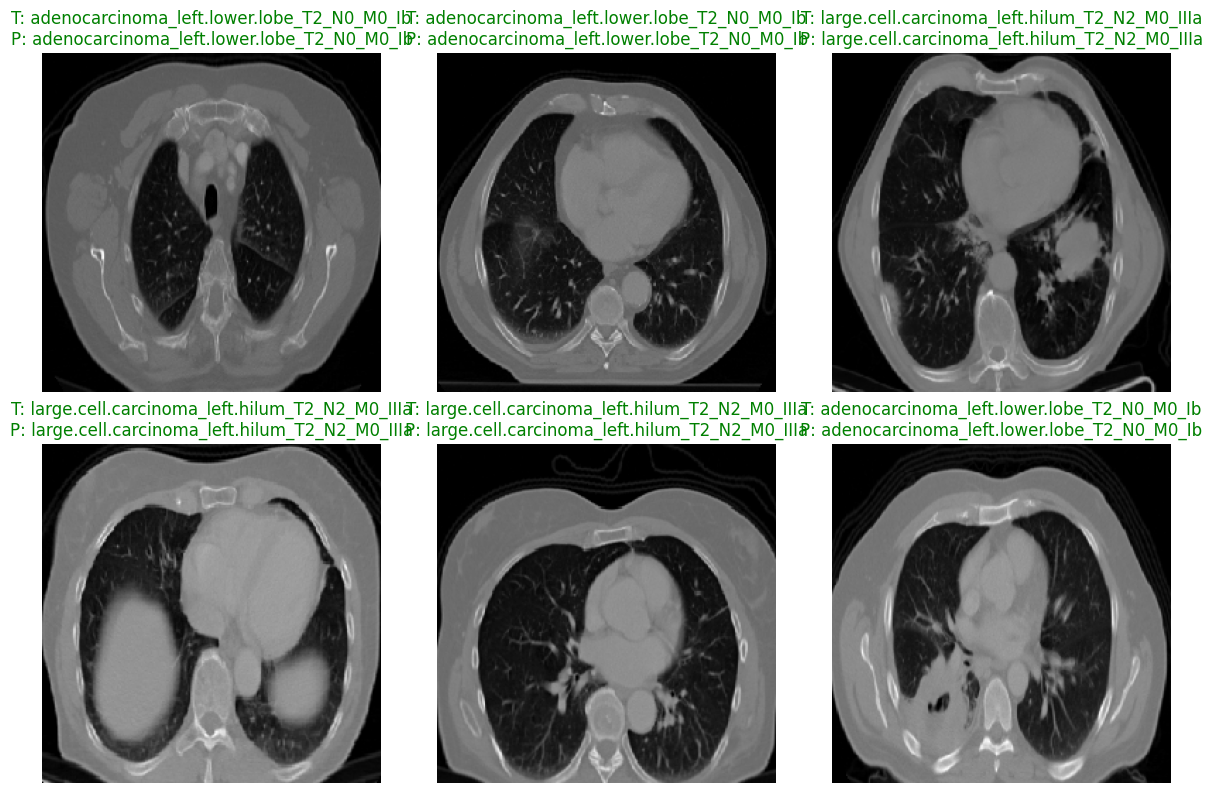

In [ ]:
import random

idx = random.sample(range(len(Y_true)), 6)
plt.figure(figsize=(12, 8))
for i, index in enumerate(idx):
    img_path = val_generator.filepaths[index]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    true_lbl = class_labels[Y_true[index]]
    pred_lbl = class_labels[Y_pred_classes[index]]
    plt.title(f"T: {true_lbl}\nP: {pred_lbl}", color='green' if true_lbl == pred_lbl else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()


Model Evaluation on Test Set

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss :", test_loss)
print("Test Accuracy :", test_acc)



Found 315 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 91s 9s/step - accuracy: 0.9242 - loss: 0.2693
Test Loss : 0.5659027099609375
Test Accuracy : 0.8253968358039856


In [ ]:
# === SHARED SETUP (Run this only once before any folds) ===
import os, random, shutil, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications.efficientnet import EfficientNetB1, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')



DATA_DIR = "/content/drive/MyDrive/lung_data/train"

# Seed and config
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
IMG_SIZE = (240, 240)
BATCH_SIZE = 32

# Load dataset into DataFrame
filepaths, labels = [], []
for label in os.listdir(DATA_DIR):
    class_folder = os.path.join(DATA_DIR, label)
    for fname in os.listdir(class_folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(class_folder, fname))
            labels.append(label)

df = pd.DataFrame({'filename': filepaths, 'label': labels})
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)


Mounted at /content/drive


In [ ]:
# === Fold 1 Training ===
fold = 0
train_idx, val_idx = list(kf.split(df, df['label']))[fold]
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]

train_gen = ImageDataGenerator(
    rotation_range=10, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05,
    brightness_range=[0.9, 1.1], preprocessing_function=preprocess_input
).flow_from_dataframe(
    train_df, x_col='filename', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    val_df, x_col='filename', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

# Build model
num_classes = len(train_gen.class_indices)
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in base_model.layers: layer.trainable = True
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Callbacks
model_path = f"best_model_fold{fold+1}.keras"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-6)
]

# Training
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=32, callbacks=callbacks, verbose=1)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks, verbose=1)

# Evaluate
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"📊 Fold {fold+1} Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

# Save model to Drive
drive_model_path = f"/content/drive/MyDrive/lung_project/models/best_model_fold{fold+1}.keras"
os.makedirs(os.path.dirname(drive_model_path), exist_ok=True)
shutil.move(model_path, drive_model_path)

# Save results to CSV
results_path = "/content/drive/MyDrive/lung_project/fold_results.csv"
fold_result = pd.DataFrame([[fold+1, val_acc, val_loss]], columns=["Fold", "Accuracy", "Loss"])
if os.path.exists(results_path):
    fold_result.to_csv(results_path, mode='a', header=False, index=False)
else:
    fold_result.to_csv(results_path, mode='w', header=True, index=False)

print(f"✅ Fold {fold+1} completed and saved.")


Found 540 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/32
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5415 - loss: 1.0845 
Epoch 1: val_accuracy improved from -inf to 0.81481, saving model to best_model_fold1.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 419s 20s/step - accuracy: 0.5461 - loss: 1.0738 - val_accuracy: 0.8148 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 2/32
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8516 - loss: 0.4195 
Epoch 2: val_accuracy improved from 0.81481 to 0.82222, saving model to best_model_fold1.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 314s 18s/step - accuracy: 0.8521 - loss: 0.4167 - val_accuracy: 0.8222 - val_loss: 0.4444 - learning_rate: 0.0010
Epoch 3/32
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9622 - loss: 0.1458 
Epoch 3: val_accuracy improved from 0.82222 to 0.86667, saving model to best_model_fold1.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 298s 17s/step - accuracy: 0.9615 - loss: 0.1482 - val_accuracy: 0.8667 - val_loss: 0.4402 - learning_rate: 0.0010
Epoch 4/32
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
# === Fold 2 Training ===
fold = 1
train_idx, val_idx = list(kf.split(df, df['label']))[fold]
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]

train_gen = ImageDataGenerator(
    rotation_range=10, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05,
    brightness_range=[0.9, 1.1], preprocessing_function=preprocess_input
).flow_from_dataframe(
    train_df, x_col='filename', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    val_df, x_col='filename', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

# Build model
num_classes = len(train_gen.class_indices)
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in base_model.layers: layer.trainable = True
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Callbacks
model_path = f"best_model_fold{fold+1}.keras"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-6)
]

# Train
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=32, callbacks=callbacks, verbose=1)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks, verbose=1)

# Evaluate and save
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"📊 Fold {fold+1} Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
drive_model_path = f"/content/drive/MyDrive/lung_project/models/best_model_fold{fold+1}.keras"
os.makedirs(os.path.dirname(drive_model_path), exist_ok=True)
shutil.move(model_path, drive_model_path)

# Save fold result to CSV
results_path = "/content/drive/MyDrive/lung_project/fold_results.csv"
fold_result = pd.DataFrame([[fold+1, val_acc, val_loss]], columns=["Fold", "Accuracy", "Loss"])
if os.path.exists(results_path):
    fold_result.to_csv(results_path, mode='a', header=False, index=False)
else:
    fold_result.to_csv(results_path, mode='w', header=True, index=False)

print(f"✅ Fold {fold+1} completed and saved.")


In [ ]:
# === Fold 3 Training ===
fold = 2
train_idx, val_idx = list(kf.split(df, df['label']))[fold]
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]

train_gen = ImageDataGenerator(
    rotation_range=10, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05,
    brightness_range=[0.9, 1.1], preprocessing_function=preprocess_input
).flow_from_dataframe(
    train_df, x_col='filename', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    val_df, x_col='filename', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

# Build model
num_classes = len(train_gen.class_indices)
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in base_model.layers: layer.trainable = True
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Callbacks
model_path = f"best_model_fold{fold+1}.keras"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-6)
]

# Train
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=32, callbacks=callbacks, verbose=1)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks, verbose=1)

# Evaluate and save
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"📊 Fold {fold+1} Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
drive_model_path = f"/content/drive/MyDrive/lung_project/models/best_model_fold{fold+1}.keras"
os.makedirs(os.path.dirname(drive_model_path), exist_ok=True)
shutil.move(model_path, drive_model_path)

# Save fold result to CSV
results_path = "/content/drive/MyDrive/lung_project/fold_results.csv"
fold_result = pd.DataFrame([[fold+1, val_acc, val_loss]], columns=["Fold", "Accuracy", "Loss"])
if os.path.exists(results_path):
    fold_result.to_csv(results_path, mode='a', header=False, index=False)
else:
    fold_result.to_csv(results_path, mode='w', header=True, index=False)

print(f"✅ Fold {fold+1} completed and saved.")


In [ ]:
# === Fold 4 Training ===
fold = 3
train_idx, val_idx = list(kf.split(df, df['label']))[fold]
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]

train_gen = ImageDataGenerator(
    rotation_range=10, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05,
    brightness_range=[0.9, 1.1], preprocessing_function=preprocess_input
).flow_from_dataframe(
    train_df, x_col='filename', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    val_df, x_col='filename', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

# Build model
num_classes = len(train_gen.class_indices)
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in base_model.layers: layer.trainable = True
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Callbacks
model_path = f"best_model_fold{fold+1}.keras"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-6)
]

# Train
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=32, callbacks=callbacks, verbose=1)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks, verbose=1)

# Evaluate and save
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"📊 Fold {fold+1} Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
drive_model_path = f"/content/drive/MyDrive/lung_project/models/best_model_fold{fold+1}.keras"
os.makedirs(os.path.dirname(drive_model_path), exist_ok=True)
shutil.move(model_path, drive_model_path)

# Save fold result to CSV
results_path = "/content/drive/MyDrive/lung_project/fold_results.csv"
fold_result = pd.DataFrame([[fold+1, val_acc, val_loss]], columns=["Fold", "Accuracy", "Loss"])
if os.path.exists(results_path):
    fold_result.to_csv(results_path, mode='a', header=False, index=False)
else:
    fold_result.to_csv(results_path, mode='w', header=True, index=False)

print(f"✅ Fold {fold+1} completed and saved.")


In [ ]:
# === Fold 5 Training ===
fold = 4
train_idx, val_idx = list(kf.split(df, df['label']))[fold]
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]

train_gen = ImageDataGenerator(
    rotation_range=10, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05,
    brightness_range=[0.9, 1.1], preprocessing_function=preprocess_input
).flow_from_dataframe(
    train_df, x_col='filename', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    val_df, x_col='filename', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

# Build model
num_classes = len(train_gen.class_indices)
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in base_model.layers: layer.trainable = True
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Callbacks
model_path = f"best_model_fold{fold+1}.keras"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-6)
]

# Train
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=32, callbacks=callbacks, verbose=1)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks, verbose=1)

# Evaluate and save
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"📊 Fold {fold+1} Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
drive_model_path = f"/content/drive/MyDrive/lung_project/models/best_model_fold{fold+1}.keras"
os.makedirs(os.path.dirname(drive_model_path), exist_ok=True)
shutil.move(model_path, drive_model_path)

# Save fold result to CSV
results_path = "/content/drive/MyDrive/lung_project/fold_results.csv"
fold_result = pd.DataFrame([[fold+1, val_acc, val_loss]], columns=["Fold", "Accuracy", "Loss"])
if os.path.exists(results_path):
    fold_result.to_csv(results_path, mode='a', header=False, index=False)
else:
    fold_result.to_csv(results_path, mode='w', header=True, index=False)

print(f"✅ Fold {fold+1} completed and saved.")


In [ ]:
import pandas as pd

# Load results from CSV
results_path = "/content/drive/MyDrive/lung_project/fold_results.csv"
results_df = pd.read_csv(results_path)

# Print per-fold results
print("🔍 Fold-wise Accuracy Summary:")
for index, row in results_df.iterrows():
    print(f"Fold {int(row['Fold'])}: Accuracy = {row['Accuracy']:.4f}, Loss = {row['Loss']:.4f}")

# Print mean and std
mean_acc = results_df['Accuracy'].mean()
std_acc = results_df['Accuracy'].std()
print(f"\n📈 Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


 Model Demonstration